## Regresión para series de tiempo

Un problema bastante común es la predicción de valores en el futuro basado en observaciones pasadas,existiendo diversas aplicaciones tanto en las áreas de economía, medicina, meteorología, transporte, energía, etc. En esta primera parte analizaremos una serie de tiempo de consumo de energía usando basándonos en observaciones anteriores y en representaciones cronológicas.

<img src="https://images.theconversation.com/files/214152/original/file-20180410-566-1v4l0o8.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop"  style="width:12cm;"  />

Con este fin utilizaremos el dataset de Kaggle "Hourly Energy Consumption" (https://www.kaggle.com/robikscube/hourly-energy-consumption), descargando tan solo el archivo AER_hourly.csv. Para realizar las predicciones probaremos utilizar árboles de regresión, regresión lineal y redes neuronales, comparando los distintos desempeños y las ventajas y desventajas de cada aproximación.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive'
%cd 'My Drive/Tarea 3/Problema 1'
%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive
/content/gdrive/My Drive/Tarea 3/Problema 1


'/content/gdrive/My Drive/Tarea 3/Problema 1'

### Paquetes a Utilizar

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor

### 1.a Carga y exploración de datos

i) cargue los datos y ordene los datos según la fecha utilizando este código (no modificar, salvo el lugar de dónde se carga el archivo.csv). Utilizaremos tan solo la dat de los últimos 3 años.

In [4]:
#Cargar datos
df = pd.read_csv('AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df.Datetime,infer_datetime_format = True)    # Pasar a formato fecha
df = df.sort_values(by = 'Datetime')                                         # Para ordenar la data
df = df.iloc[np.where(df.Datetime == "2016-01-01 00:00:00")[0][0]:,:]        # Dejar datos del 2016 en adelante

In [5]:
df.head()  # Primeros datos

,Datetime,AEP_MW
89857,2016-01-01 00:00:00,13487.0
107354,2016-01-01 01:00:00,13135.0
107355,2016-01-01 02:00:00,12912.0
107356,2016-01-01 03:00:00,12685.0
107357,2016-01-01 04:00:00,12631.0


In [6]:
df.tail()  # Ultimos datos

,Datetime,AEP_MW
116157,2018-08-02 20:00:00,17673.0
116158,2018-08-02 21:00:00,17303.0
116159,2018-08-02 22:00:00,17001.0
116160,2018-08-02 23:00:00,15964.0
116161,2018-08-03 00:00:00,14809.0


ii) Utilizando la columna AEP_MW, correspondiente al consumo de potencia en MW para cada fecha, realice una exploración de la data, indexando según el año, día del año, día de la semana y hora, de manera separada. Grafique, con la herramienta que estime conveniente, la distribución del consumo para cada indexación. Guíese con el siguiente ejemplo. Utilice herramientas tal como boxplots. Acompañe los gráficos con un análisis escrito breve.

In [7]:
# Paleta de colores a utilizar
cols = sns.color_palette("cubehelix",3)

time = pd.to_datetime(np.asarray(df.Datetime))         # Tiempo del data set

# Lista para guardar MW segun indexación
MW_per_year       = []                                       
MW_per_dayofyear  = []
MW_per_dayofweek  = []
MW_per_hour       = []

# array con los años del dataset
years     = np.linspace(min(time.year),max(time.year),max(time.year)-min(time.year)+1,dtype = 'int')
dayofyear = np.linspace(min(time.dayofyear),max(time.dayofyear),max(time.dayofyear)-min(time.dayofyear)+1,dtype = 'int')
dayofweek = np.linspace(min(time.dayofweek),max(time.dayofweek),max(time.dayofweek)-min(time.dayofweek)+1,dtype = 'int')
hour      = np.linspace(min(time.hour),max(time.hour),max(time.hour)-min(time.hour)+1,dtype = 'int')

# Crea una lista con 3 matrices que contiene los MW por cada año
for i in years:
    MW_per_year.append(np.asarray(df.AEP_MW[time.year == i]))
    
for i in dayofyear:
    MW_per_dayofyear.append(np.asarray(df.AEP_MW[time.dayofyear == i]))
    
for i in dayofweek:
    MW_per_dayofweek.append(np.asarray(df.AEP_MW[time.dayofweek == i]))
    
for i in hour:
    MW_per_hour.append(np.asarray(df.AEP_MW[time.hour == i]))

**MW por año**

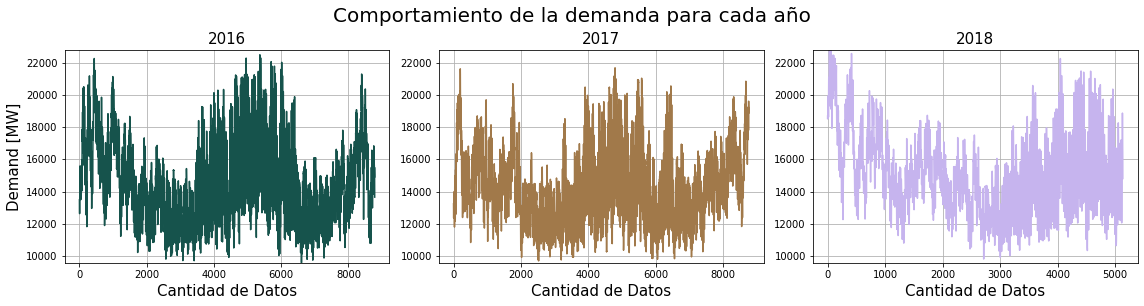

In [8]:
# Gráficos 
plt.rcParams['figure.figsize'] = [16,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para cada año",y = 1.05, size = 20)   # Titulo

for i in range(max(time.year)-min(time.year)+1):
    plt.subplot(1,3,i+1)
    plt.plot(MW_per_year[i],color = cols[i])
    plt.title(str(years[i]), size = 15)
    plt.tight_layout()
    plt.ylim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    
    if i == 0: 
        plt.ylabel("Demand [MW]", size = 15)
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.grid()
plt.show()

**Comentarios:** El eje x corresponde a la cantidad de datos y el eje y es la demanda. Se puede ver que para todos los años se ve un comportamiento sinusoidal, donde se completa un ciclo con aproximadamente 6000 datos.

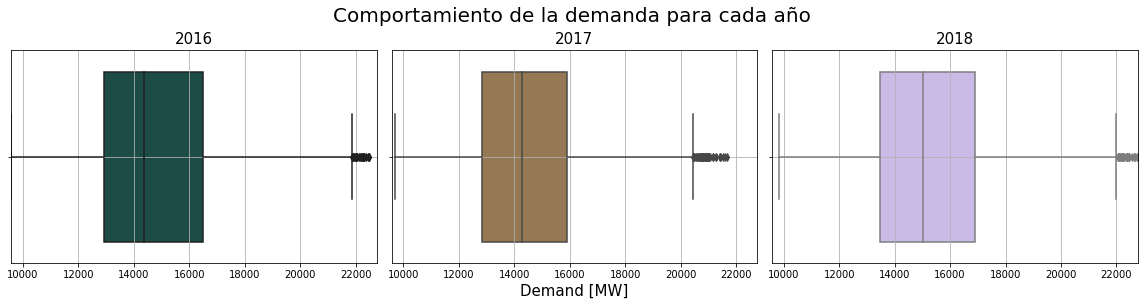

In [ ]:
plt.rcParams["figure.figsize"] = [16,4]
plt.suptitle("Comportamiento de la demanda para cada año", y=1.05,size = 20)

for i in range(max(time.year)-min(time.year)+1):
    plt.subplot(1,3,i+1)
    sns.boxplot(MW_per_year[i],color = cols[i])
    plt.title(str(years[i]),size =15)
    plt.tight_layout()
    plt.xlim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    
    if i == 1:
        plt.xlabel("Demand [MW]",size = 15)
    plt.grid()
plt.show()

**MW por días del año**

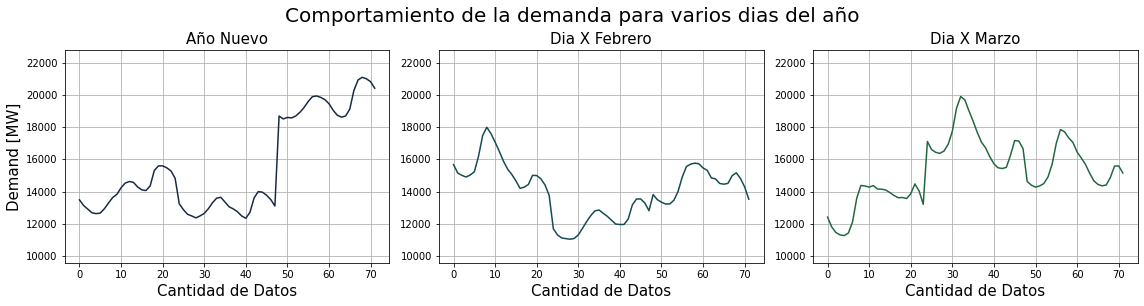

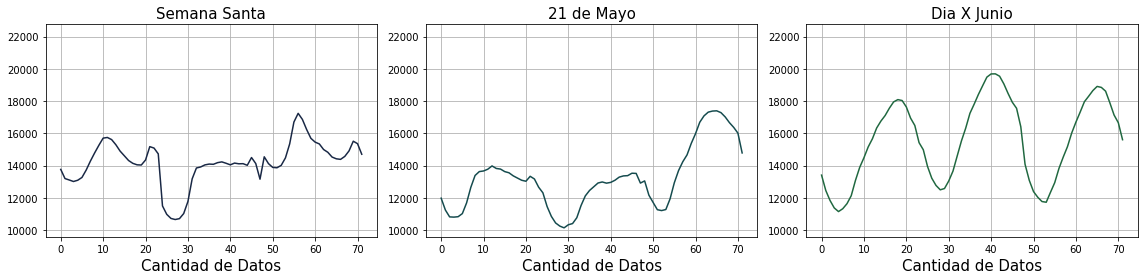

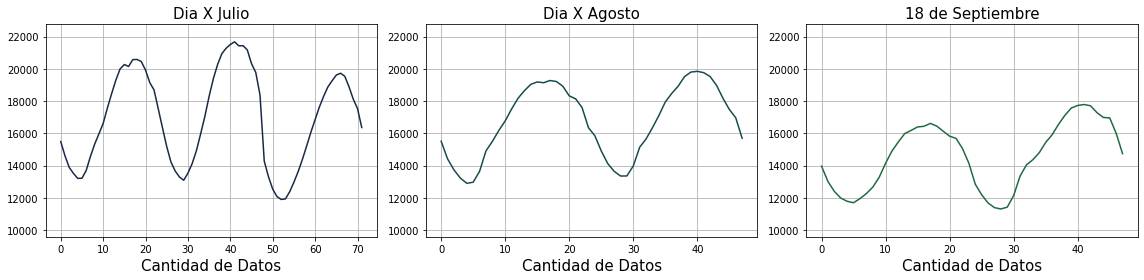

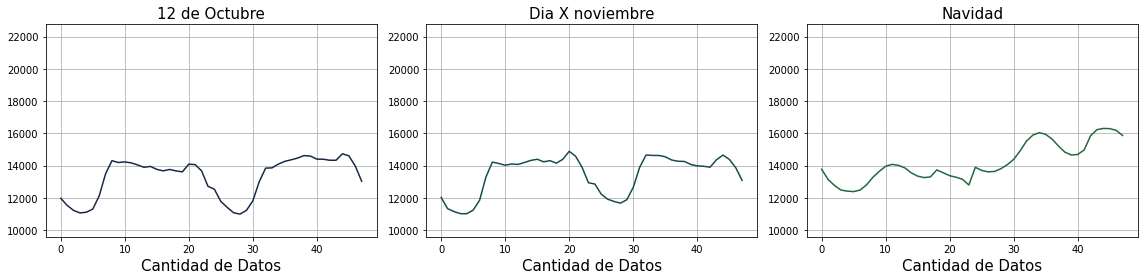

In [ ]:
# Gráficos 
plt.rcParams['figure.figsize'] = [16,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para varios dias del año",y = 1.05, size = 20)   # Titulo
cols = sns.color_palette("cubehelix",12)

days = np.array([1,50,75,100,141,165,200,230,261,285,306,359])-1
name = ['Año Nuevo', 'Dia X Febrero','Dia X Marzo','Semana Santa',
        '21 de Mayo','Dia X Junio','Dia X Julio','Dia X Agosto',
       '18 de Septiembre', '12 de Octubre', 'Dia X noviembre', 'Navidad']
k = 1
j = 0
for i in days:
    plt.subplot(1,3,k)
    plt.plot(MW_per_dayofyear[i],color = cols[k])
    plt.title(name[j], size = 15)
    plt.tight_layout()
    plt.ylim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    plt.grid()
    plt.xlabel("Cantidad de Datos", size = 15)
    j+=1
    if k==3:
        k=1
        plt.show()
    else:
        k+=1
    if i == 0: 
        plt.ylabel("Demand [MW]", size = 15)

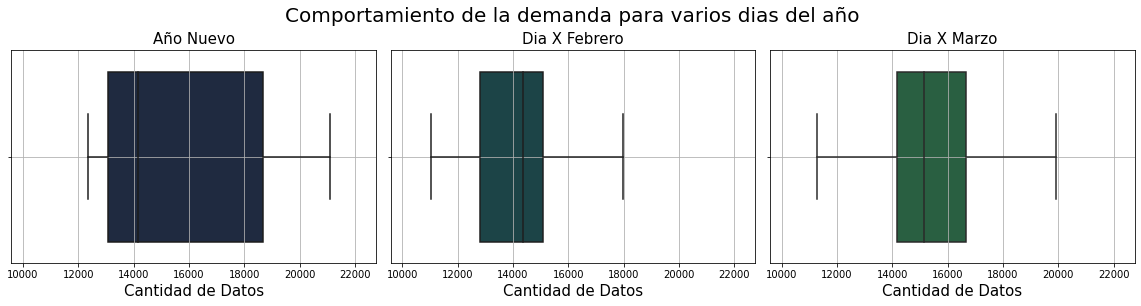

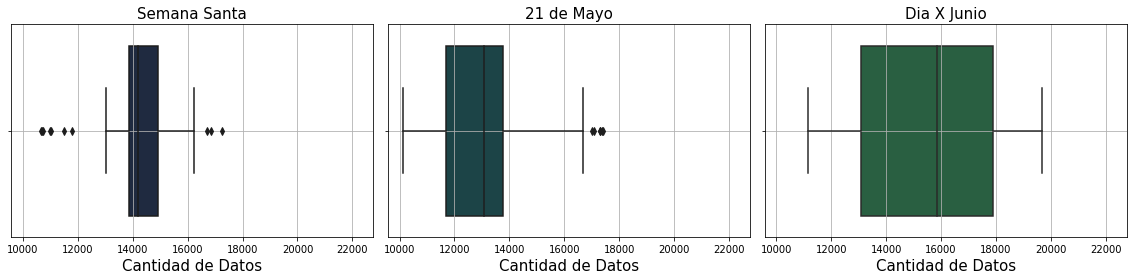

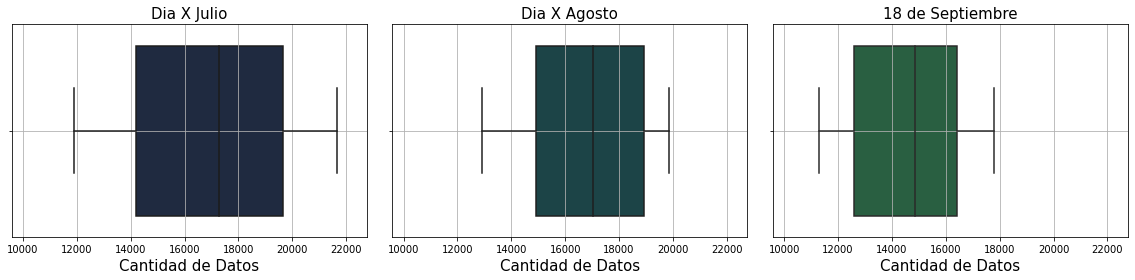

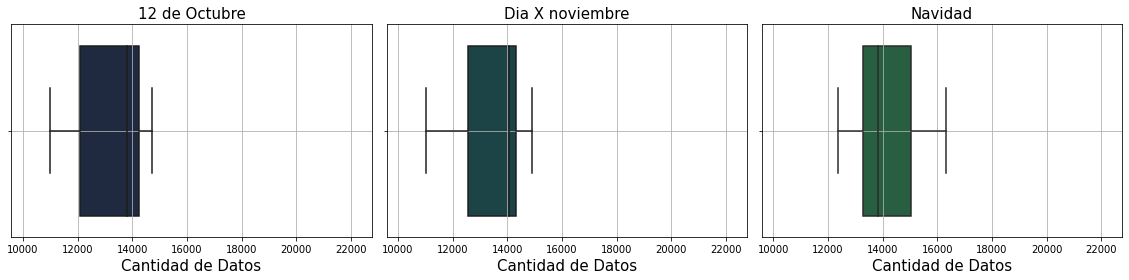

In [ ]:
plt.rcParams["figure.figsize"] = [16,4]
plt.suptitle("Comportamiento de la demanda para varios dias del año", y=1.05,size = 20)

k = 1
j = 0
for i in days:
    plt.subplot(1,3,k)
    sns.boxplot(MW_per_dayofyear[i],color = cols[k])
    plt.title(name[j], size = 15)
    plt.tight_layout()
    plt.grid()
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.xlim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    j += 1
    if k==3:
        k=1
        plt.show()
    else:
        k+=1
              

#### MW día por semana

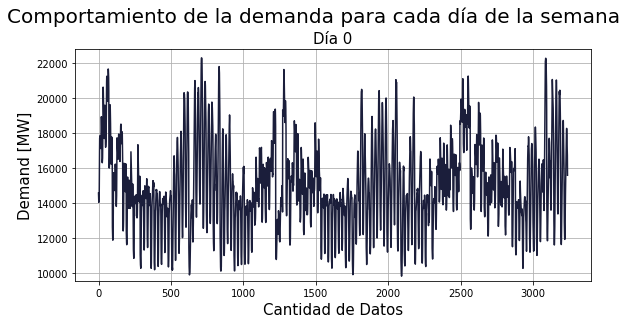

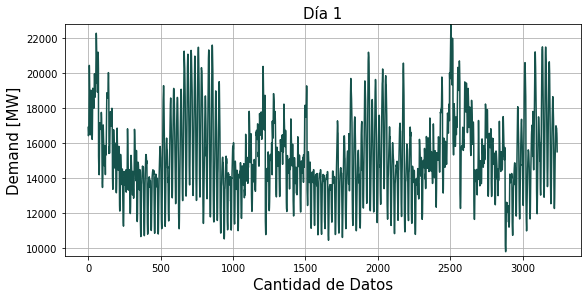

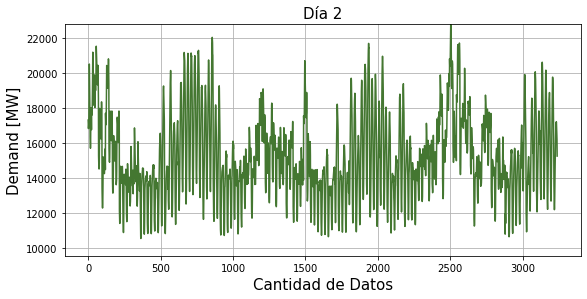

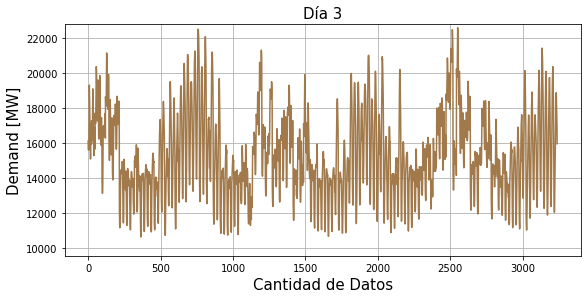

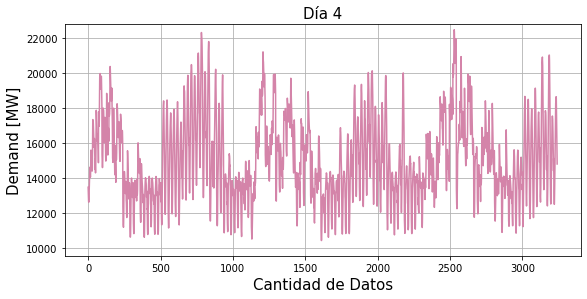

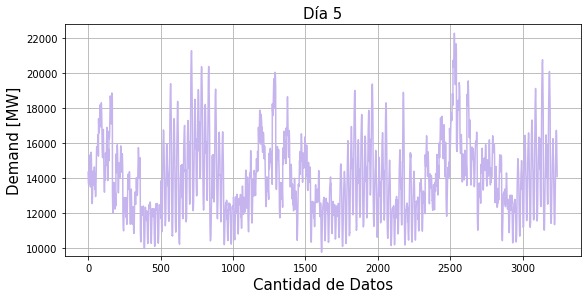

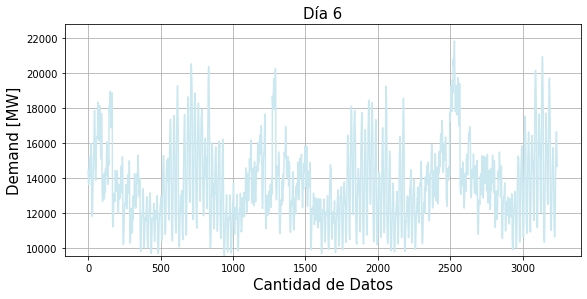

In [9]:
# Gráficos 
plt.rcParams['figure.figsize'] = [8,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para cada día de la semana",y = 1.05, size = 20)   # Titulo
cols = sns.color_palette("cubehelix",7)

k=1
j=0
for i in range(max(time.dayofweek)-min(time.dayofweek)+1):
    plt.subplot(1,1,k)
    plt.plot(MW_per_dayofweek[i],color = cols[j])
    plt.title('Día'+' '+str(dayofweek[i]), size = 15)
    plt.tight_layout()
    plt.ylim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    plt.ylabel("Demand [MW]", size = 15)
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.grid()
    j+=1
    if k==1:
        k=1
        plt.show()
    else:
        k+=1

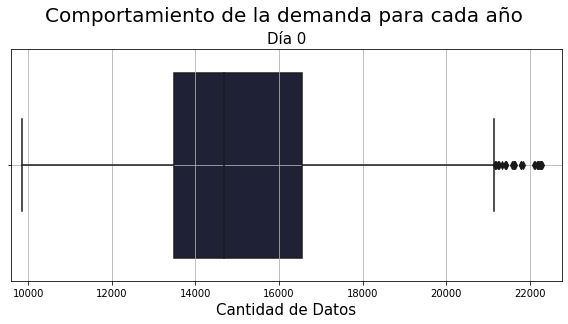

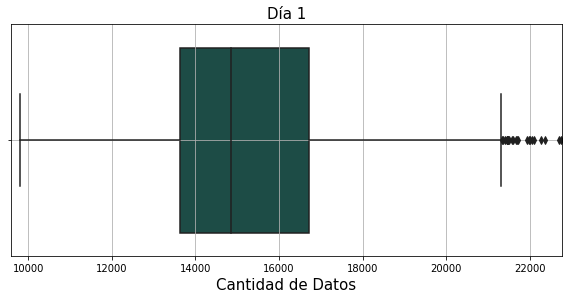

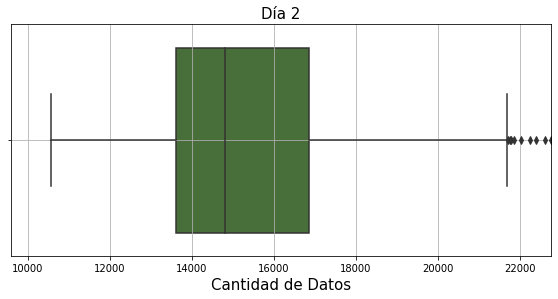

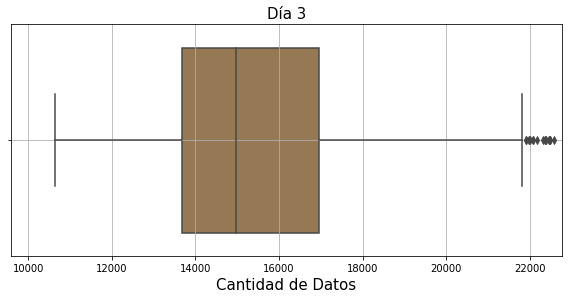

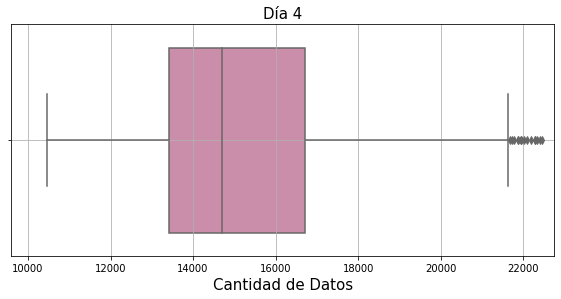

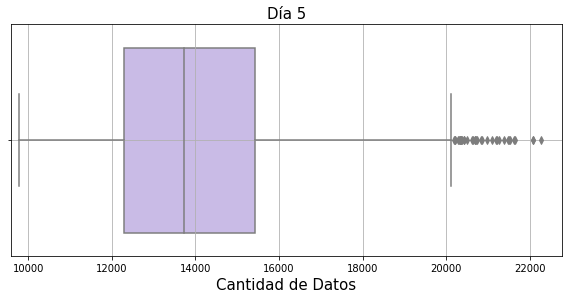

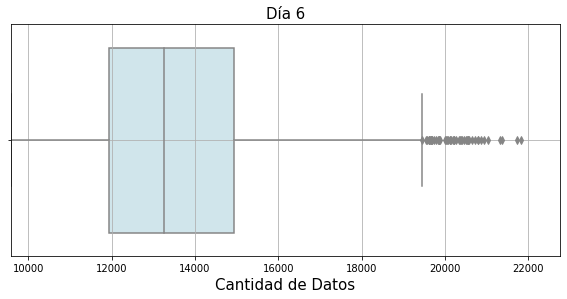

In [10]:
# Gráficos 
plt.rcParams['figure.figsize'] = [8,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para cada año",y = 1.05, size = 20)   # Titulo

k=1
j=0
for i in range(max(time.dayofweek)-min(time.dayofweek)+1):
    plt.subplot(1,1,k)
    sns.boxplot(MW_per_dayofweek[i],color = cols[j])
    plt.title('Día'+' '+str(dayofweek[i]), size = 15)
    plt.tight_layout()
    plt.grid()
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.xlim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    j+=1
    if k==1:
        k=1
        plt.show()
    else:
        k+=1

**MW por hora**

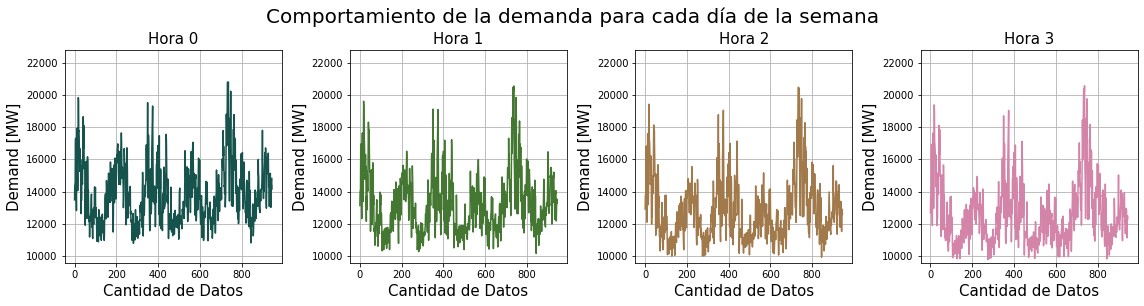

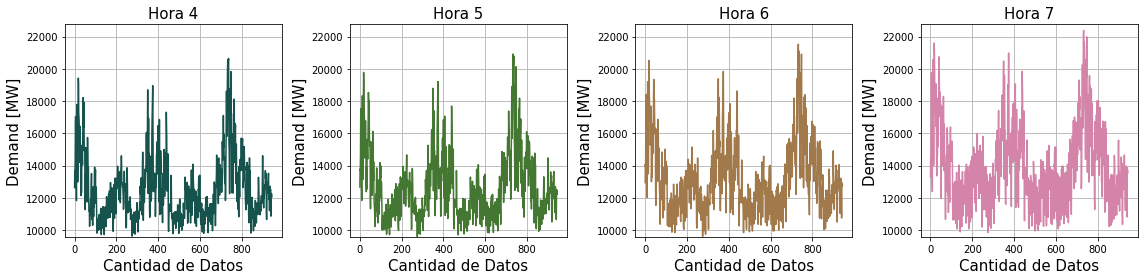

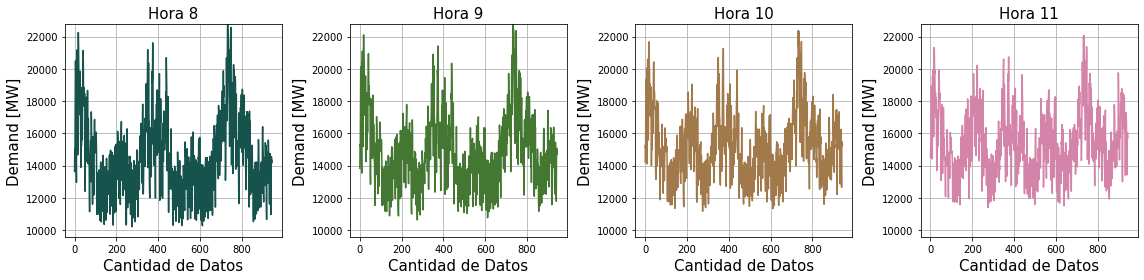

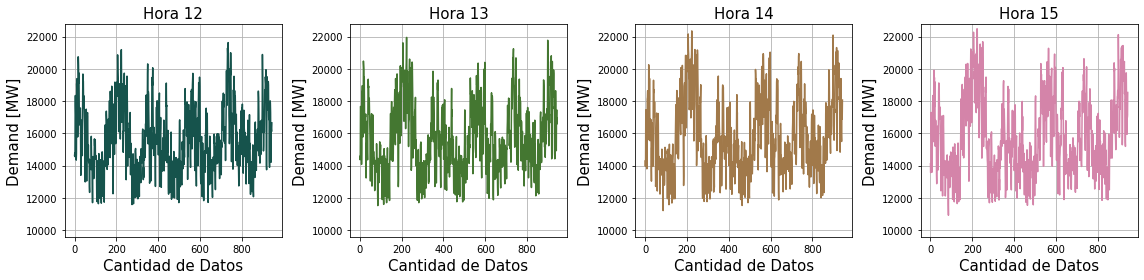

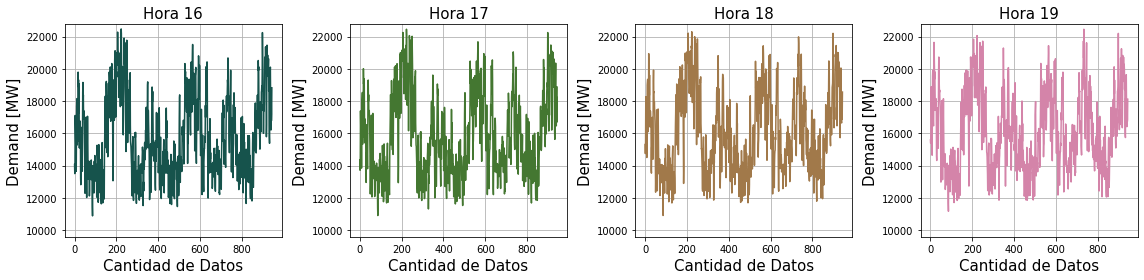

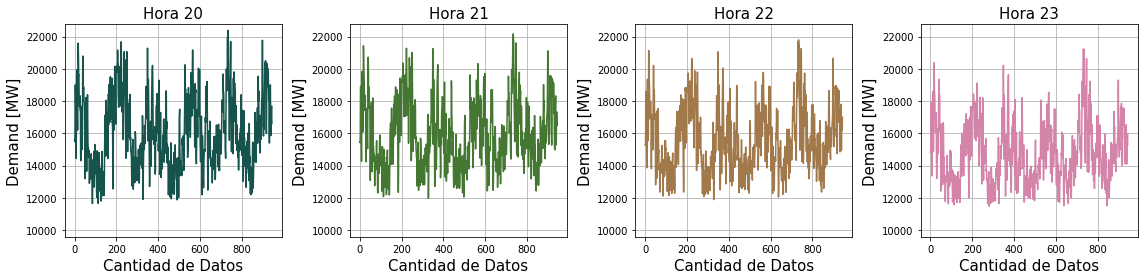

In [11]:
# Gráficos 
plt.rcParams['figure.figsize'] = [16,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para cada día de la semana",y = 1.05, size = 20)   # Titulo
cols = sns.color_palette("cubehelix",7)

k=1
for i in range(max(time.hour)-min(time.hour)+1):
    plt.subplot(1,4,k)
    plt.plot(MW_per_hour[i],color = cols[k])
    plt.title('Hora'+' '+str(hour[i]), size = 15)
    plt.tight_layout()
    plt.ylim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    plt.ylabel("Demand [MW]", size = 15)
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.grid()
    if k==4:
        k=1
        plt.show()
    else:
        k+=1

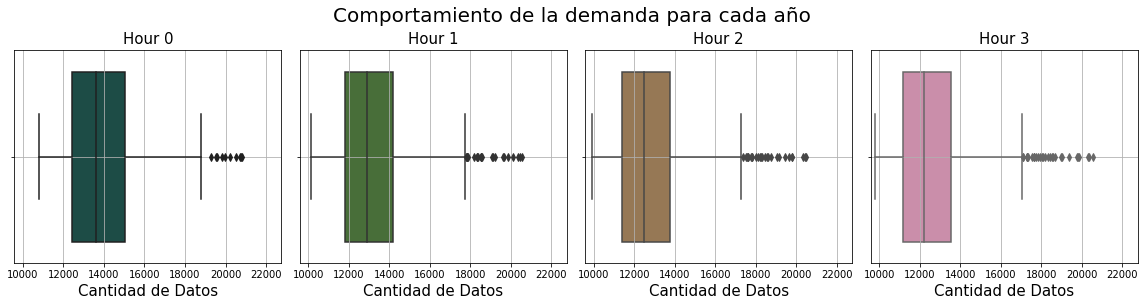

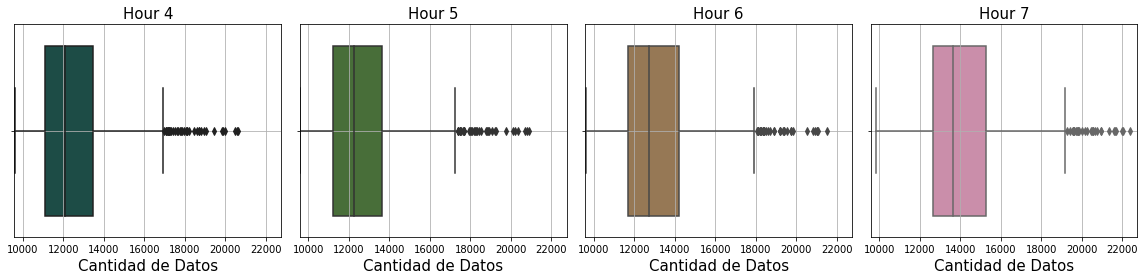

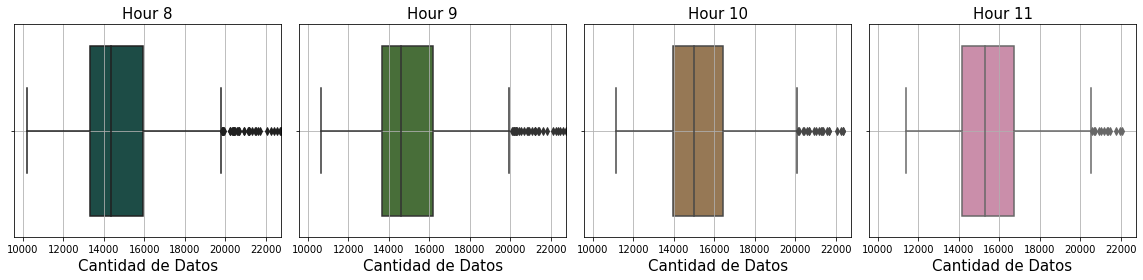

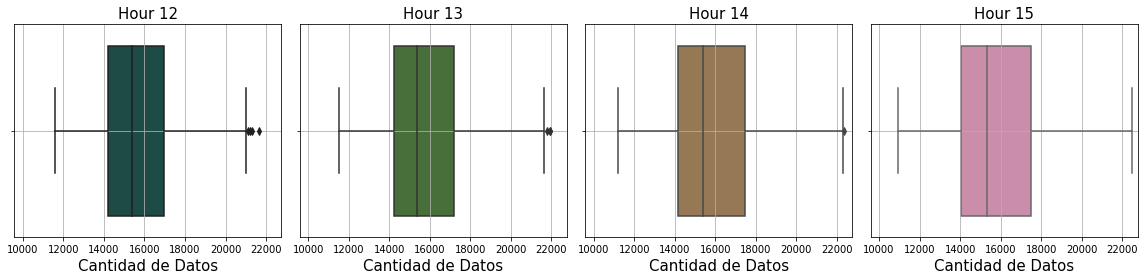

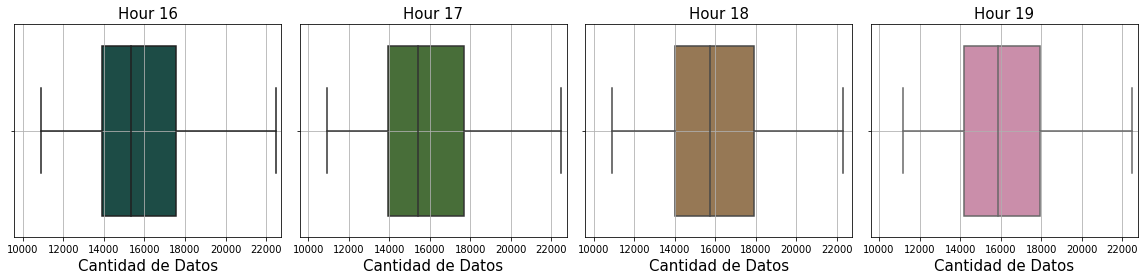

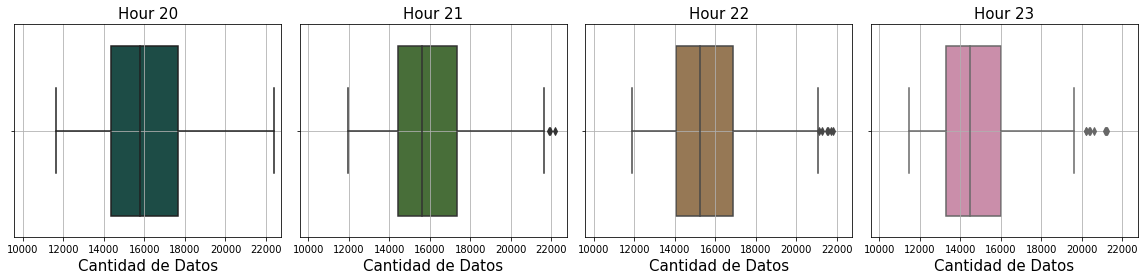

In [ ]:
# Gráficos 
plt.rcParams['figure.figsize'] = [16,4]                                          # Tamaño
plt.suptitle("Comportamiento de la demanda para cada año",y = 1.05, size = 20)   # Titulo

k=1
for i in range(max(time.hour)-min(time.hour)+1):
    plt.subplot(1,4,k)
    sns.boxplot(MW_per_hour[i],color = cols[k])
    plt.title('Hour'+' '+str(hour[i]), size = 15)
    plt.tight_layout()
    plt.grid()
    plt.xlabel("Cantidad de Datos", size = 15)
    plt.xlim([np.min(df.AEP_MW),np.max(df.AEP_MW)])
    if k==4:
        k=1
        plt.show()
    else:
        k+=1

**1.b Preprocesamiento de los datos**

i) Para realizar predicciones 24 horas adelante usaremos las últimas 24 observaciones de demanda (demanda = consumo de potencia eléctrica) y la representación cronológica de la última observación. Utilice el siguiente código para crear las variables de entrada y salida utilizando el dataset original ordenado (No es necesario modificar el código).

In [12]:
df = pd.read_csv("AEP_hourly.csv")
df["Datetime"] = pd.to_datetime(df.Datetime, infer_datetime_format = True)
df = df.sort_values(by='Datetime') 
df = df.iloc[np.where(df.Datetime == '2016-01-01 00:00:00')[0][0]:,:]

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
inp, out = split_sequence(np.asarray(df),24,24)  # Obtiene matrices X e Y

Debiese obtener una salida de la siguiente forma:

Input shape: (22633,24,2) [Cant. de recortes serie de tiempos generados, largo serie de tiempo, (timeindex,MW)]

Output shape: (22633,24,2) [Cant. de recortes serie de tiempo generados, largo serie de tiempo, (timeindex,MW)]

ii) Antes de eliminar el time index en la tercera dimensión, lo utilizaremos para crear "relojes" para la hora, día de la semana, y día del año de la última observación. Utilice el siguiente código para generar X e Y.

In [14]:
# Se pasa la hora, semanas y dias del año a reloj 
hour_1 = np.asarray(np.sin(2*pi*pd.to_datetime(inp[:,-1,0]).hour/24)).reshape(-1,1)
hour_2 = np.asarray(np.cos(2*pi*pd.to_datetime(inp[:,-1,0]).hour/24)).reshape(-1,1)
week_1 = np.asarray(np.sin(2*pi*pd.to_datetime(inp[:,-1,0]).dayofweek/7)).reshape(-1,1)
week_2 = np.asarray(np.cos(2*pi*pd.to_datetime(inp[:,-1,0]).dayofweek/7)).reshape(-1,1)
day_1  = np.asarray(np.sin(2*pi*pd.to_datetime(inp[:,-1,0]).dayofyear/7)).reshape(-1,1)
day_2  = np.asarray(np.cos(2*pi*pd.to_datetime(inp[:,-1,0]).dayofyear/7)).reshape(-1,1)

# Input queda MW,los relojes hour1, hour2, week1, week2, day1 y day2.
X = np.concatenate((inp[:,:,1],hour_1,hour_2,week_1,week_2,day_1,day_2),axis=1).copy()
Y = out[:,:,1].copy()

iii) Utilice como conjunto de test los datos desde el año 2018. Cree los conjuntos de entrenamiento y validación de la forma que estime conveniente. Justifique su elección.

In [15]:
# Se obtiene train, validation y test set
x_tst, y_tst = X[pd.to_datetime(out[:,-1,0]).year == 2018], Y[pd.to_datetime(out[:,-1,0]).year == 2018]
x_tr_val, y_tr_val = X[pd.to_datetime(out[:,-1,0]).year != 2018], Y[pd.to_datetime(out[:,-1,0]).year != 2018]
x_tr,x_val,y_tr,y_val = train_test_split(x_tr_val,y_tr_val, test_size = 0.2)

# Porcentaje del set
print('El train set corresponde a', np.round(x_tr.shape[0]/X.shape[0]*100,2),'del total')
print('El validation set corresponde a', np.round(x_val.shape[0]/X.shape[0]*100,2),'del total')
print('El test set corresponde a', np.round(x_tst.shape[0]/X.shape[0]*100,2),'del total')

El train set corresponde a 61.84 del total
El validation set corresponde a 15.46 del total
El test set corresponde a 22.69 del total


**Comentarios:**

iv) Estandarice cada una de las columnas de los datos del modo que estime conveniente, justifue su elección.

In [16]:
# Estandarizado las variables
scaler_x  = StandardScaler()
scaler_y  = StandardScaler()  

# Variable x_tr e y_tr
scaler_x.fit (x_tr)                             
x_tr_st = scaler_x.transform(x_tr)

scaler_y.fit(y_tr)
y_tr_st = scaler_y.transform(y_tr)

# Variable x_val e y_val
x_val_st = scaler_x.transform(x_val)
y_val_st = scaler_y.transform(y_val)

# Variable x_tst e y_tst
x_tst_st = scaler_x.transform(x_tst)
y_tst_st = scaler_y.transform(y_tst)

**1.c Primer Árbol**

i) Entrenaremos ahora un árbol de regresión con profundidad 3, utilizaremos %timeit para obtener el tiempo de entrenamiento. Utilizaremos como métrica para el entrenamiento el Error Absoluto Medio o MAE a lo largo de esta pregunta.

In [17]:
# Ajuste del primer árbol con profundidad 3
tree = DecisionTreeRegressor(criterion = 'mae', max_depth = 3)
%timeit -n 1 -r 1 tree.fit(x_tr_st, y_tr_st)

1 loop, best of 1: 8min 8s per loop


ii) Entrene también un regresor lineal

In [18]:
# Ajuste regresión lineal
linear_reg = LinearRegression()
%timeit -n 1 -r 1 linear_reg.fit(x_tr_st,y_tr_st)

1 loop, best of 1: 37.1 ms per loop


iii) Escoga 4 métrica adicionales de regresión desde el sitio https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics (serán 5 métricas incluyendo MAE). Explique la utilidad de cada métrica, evalúe con las 5 métricas los conjuntos de validación y test de ambos modelos. Concluya.

**Métricas:**

**Explained Variance Score**

Se puede calcular de la siguiente forma
$$\text {explained_variance}(y, \hat{y})=1-\frac{\operatorname{Var}\{y-\hat{y}\}}{\operatorname{Var}\{y\}}$$
donde $y$ es el target correcto, $\hat{y}$ es el target estimado y $\text{Var}$ corresponde a la varianza. El mejor score posible es 1 y a medida que se tiene peor predicción disminuye el score dado que aumenta la varianza entre $y-\hat{y}$.

**Mean Squared Error**

Se puede calcular como
$$\operatorname{MSE}(y, \hat{y})=\frac{1}{n_{\text {samples }}} \sum_{i=0}^{n_{\text {samplen }}-1}\left(y_{i}-\hat{y}_{i}\right)^{2}$$
donde $y$ es el valor del target e $\hat{y}$ es la predicción del target. A menor valor de MSE mejor es el resultado.

**Median Aboslute Error**

Esta función es robusta frente a los outliers. La pérdida es calculado tomando la mediana de las diferencias absolutas entre el target y la predicción. Esto es:

$$\operatorname{Med} \operatorname{AE}(y, \hat{y})=\operatorname{median}\left(\left|y_{1}-\hat{y}_{1}\right|, \ldots,\left|y_{n}-\hat{y}_{n}\right|\right)$$

**$R^2$ score, the coefficient of determination**

Se puede calcular con la siguiente formula
$$\begin{array}{c}
R^{2}(y, \hat{y})=1-\frac{\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}} \\
\text { where } \bar{y}=\frac{1}{n} \sum_{i=1}^{n} y_{i} \text { and } \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}=\sum_{i=1}^{n} \epsilon_{i}^{2}
\end{array}$$
El valor máximo corresponde a 1 y puede ser negativo. 

In [19]:
#predicciones árbol
tree_val = tree.predict(x_val_st)
tree_tst = tree.predict(x_tst_st)

In [20]:
#predicciones lineal
linear_val = linear_reg.predict(x_val_st)
linear_tst = linear_reg.predict(x_tst_st)

In [21]:
def metrics(pred_val,pred_tst,y_val,y_tst):
    # MAE
    mae_val = mean_absolute_error(y_val,pred_val)
    mae_tst = mean_absolute_error(y_tst,pred_tst)

    # MSE
    mse_val = mean_squared_error(y_val, pred_val)
    mse_tst = mean_squared_error(y_tst, pred_tst)
    
    # MSLE
    meae_val = median_absolute_error(y_val,pred_val)
    meae_tst = median_absolute_error(y_tst,pred_tst)
    
    # R2
    r2_val = r2_score(y_val,pred_val)
    r2_tst = r2_score(y_tst,pred_tst)
    
    # EVS
    evs_val = explained_variance_score(y_val,pred_val)
    evs_tst = explained_variance_score(y_tst,pred_tst)

    # Lista con las métricas
    metrics_val = [mae_val, mse_val, meae_val, r2_val, evs_val]
    metrics_tst = [mae_tst, mse_tst, meae_tst, r2_tst, evs_tst]
    
    return metrics_val, metrics_tst

In [22]:
# Resultado de métricas para las regresiones anteriores.
metrics_tree_val, metrics_tree_tst      = metrics(tree_val, tree_tst, y_val_st, y_tst_st)
metrics_linear_val, metrics_linear_tst  = metrics(linear_val, linear_tst, y_val_st, y_tst_st)

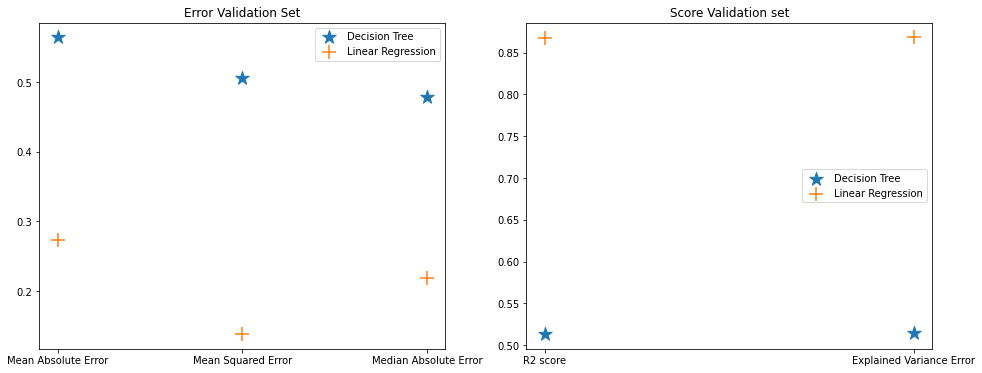

In [72]:
# Gráfico para comparar las metricas de las regresiones mencionadas
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
             'R2 score', 'Explained Variance Error']

# VALIDATION SET
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].scatter(metrics_n[:3],metrics_tree_val[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_linear_val[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_tree_val[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_linear_val[3:],200,marker='+')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Decision Tree','Linear Regression'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Decision Tree','Linear Regression'])

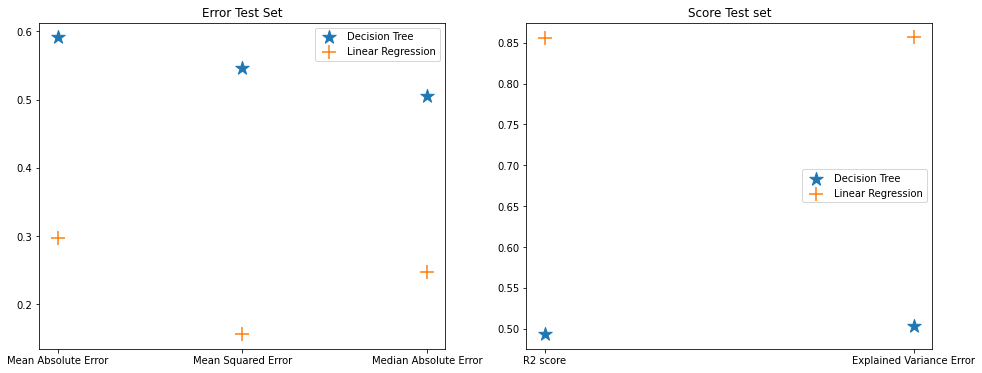

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_tree_tst[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_linear_tst[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_tree_tst[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_linear_tst[3:],200,marker='+')
axs[0].set_title("Error Test Set")
axs[0].legend(['Decision Tree','Linear Regression'])
axs[1].set_title("Score Test set")
axs[1].legend(['Decision Tree','Linear Regression'])

iv) ¿Cómo se comportan los tiempos de entrenamiento de cada modelo?¿Le parece justificado el tiempo adicional?

El tiempo de entrenamiento del árbol es muy superior al tiempo de la regresión lineal y, basándose en los gráficos de las métricas, no parece ser justificado, por lo menos para esas configuración.

**Comentarios**

Se puede ver que la regresión lineal presenta un mejor ajuste para este problema en comparación al árbol entrenado.

**1.d Stump**
Entrene ahora un Stump o árbolde profundidad 1. ¿Cómo cambia los 5 errores en validación y test con respecto al árbol de la pregunta anterior? Discuta sobre el número de parámetro entrenables que tendrá cada modelo.

In [25]:
stump = DecisionTreeRegressor(criterion = 'mae',
                             max_depth = 1)
%timeit -n 1 -r 1 stump.fit(x_tr_st, y_tr_st)

1 loop, best of 1: 4min 5s per loop


In [26]:
# Predicción de árbol stump
stump_val = stump.predict(x_val_st)
stump_tst = stump.predict(x_tst_st)

In [27]:
# Métricas
metrics_stump_val, metrics_stump_tst = metrics(stump_val, stump_tst, y_val_st, y_tst_st)

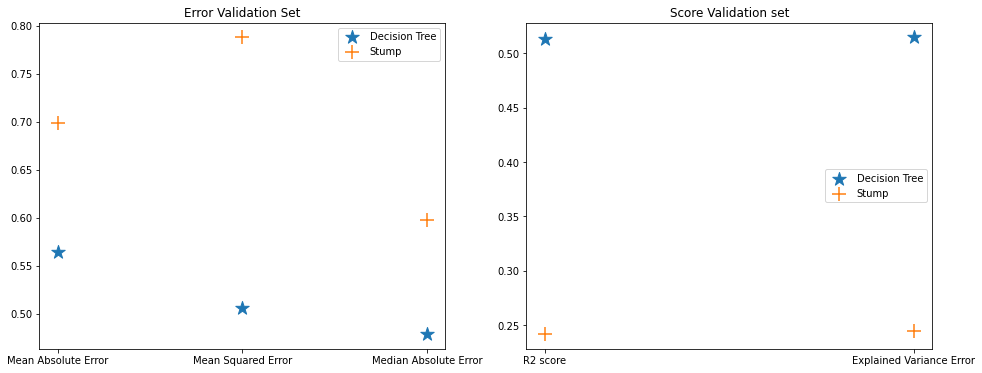

In [74]:
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# VALIDATION SET
axs[0].scatter(metrics_n[:3],metrics_tree_val[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_stump_val[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_tree_val[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_stump_val[3:],200,marker='+')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Decision Tree','Stump'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Decision Tree','Stump'])

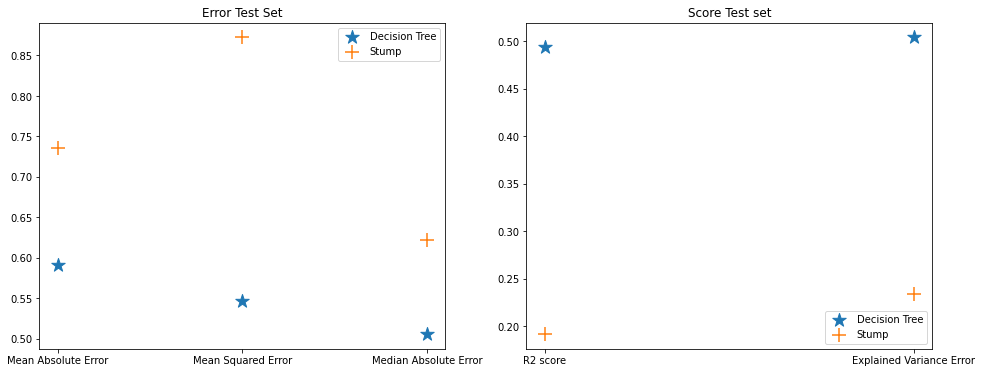

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_tree_tst[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_stump_tst[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_tree_tst[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_stump_tst[3:],200,marker='+')
axs[0].set_title("Error Test Set")
axs[0].legend(['Decision Tree','Stump'])
axs[1].set_title("Score Test set")
axs[1].legend(['Decision Tree','Stump'])

**Comentarios**

Se puede ver que el árbol de la profundidad 1 se tiene peor desempeño que el árbol de profundiad 3 por razones logicas, dado que al aumentar la profundidad disminuye la probabilidad de underfitting considerando profundidades pequeñas.

**1.e Profundidad Máxima**

Explore distintos valores de la profundad máxima del árbol. Para esto, realice K-fold sobre al menos 10 valores distintos de la profundidad del árbol y compare el promedio de los MAE de Validación. También Guarde los promedios de MAE de train y grafique cómo estos varían a medida que varía la profundidad máxima. Idealmente debería considerar un rango entre profundidad 1 y 30, con uno minimo de 10 evaluaciones. Este punto puede resultar en un largo tiempo de cómputo, podría ser recomendable correrlo en _Collab_ en caso de tener máquinas más lentas.

Finalmente, entrene el árbol con profundidad óptima sobre todos los datos de entrenamiento y calculo los 5 errores escogidos previamente sobre validación y test. ¿Mejora el desempeño obtenido anteriormente con los árboles sin sintonizar?

#### Cross - Validation 

In [ ]:
# Concatenar train set + validation set
x_tr_con = np.concatenate((x_tr_st,x_val_st), axis=0)
y_tr_con = np.concatenate((y_tr_st,y_val_st), axis=0)

# Cross Validation
depth                =  [1,3,6,9,12,15,18,21,24,27,30]
error_val_depth      =  []
error_tr_depth       =  []
fold                 =  KFold(5)
error                =  float('inf')
save_error           =  pd.DataFrame(columns=['depth','train','val'])
save_error.iloc[:,0] =  depth

for i in depth:
    error_val_fold  =  []
    error_tr_fold   =  []
    for train_index, val_index in fold.split(x_tr_con):
        x_tr_fold   =  x_tr_con[train_index]
        x_val_fold  =  x_tr_con[val_index]
        y_tr_fold   =  y_tr_con[train_index]
        y_val_fold  =  y_tr_con[val_index]
        
        # Ajustar arbol
        tree_fold  =  DecisionTreeRegressor(criterion = 'mae',
                             max_depth = i)
        tree_fold.fit(x_tr_fold, y_tr_fold)
        
        # Predicción y error validation
        pred_val  =  tree_fold.predict(x_val_fold)
        mae_val   =  mean_absolute_error(y_val_fold,pred_val)
        error_val_fold.append(mae_val)
        
        # Predicción y error train
        pred_tr  =  tree_fold.predict(x_tr_fold)
        mae_tr   =  mean_absolute_error(y_tr_fold,pred_tr)
        error_tr_fold.append(mae_tr)
    
    # Error x Fold
    error_mean_val = np.mean(error_val_fold)
    error_val_depth.append(error_mean_val)
    error_tr_depth.append(np.mean(error_tr_fold))
    
    # Depth
    if error_mean_val < error:
        error = error_mean_val
        cand_depth = i

# Para guardar resultados
save_error.iloc[:,1] = error_tr_depth
save_error.iloc[:,2] = error_val_depth
save_error.to_csv('error_crossvalidation.csv',index=False)

#### Versión sin KFold


In [ ]:
# Validation
depth                =  [1,3,6,9,12,15,18,21,24,27,30]
error_val_depth      =  []
error_tr_depth       =  []
error                =  float('inf')
save_error           =  pd.DataFrame(columns=['depth','train','val'])
save_error.iloc[:,0] =  depth

for i in depth:
          
    # Ajustar arbol
    tree_depth =  DecisionTreeRegressor(criterion = 'mae',
                             max_depth = i)
    tree_depth.fit(x_tr_st, y_tr_st)
        
    # Predicción y error validation
    pred_val  =  tree_depth.predict(x_val_st)
    mae_val   =  mean_absolute_error(y_val_st,pred_val)
    error_val_depth.append(mae_val)
        
    # Predicción y error train
    pred_tr  =  tree_depth.predict(x_tr_st)
    mae_tr   =  mean_absolute_error(y_tr_st,pred_tr)
    error_tr_depth.append(mae_tr)
    
    # Depth
    if mae_val < error:
        error = mae_val
        cand_depth = i

    print('Depth',i,'con error',error,'y Depth candidato',cand_depth)

# Para guardar resultados
save_error.iloc[:,1] = error_tr_depth
save_error.iloc[:,2] = error_val_depth
save_error.to_csv('error_validation.csv',index=False)

Depth 1 con error 0.6908645285921141 y Depth candidato 1
Depth 3 con error 0.5591439794345051 y Depth candidato 3
Depth 6 con error 0.39595608616008465 y Depth candidato 6
Depth 9 con error 0.3111850062131001 y Depth candidato 9
Depth 12 con error 0.28958664012111546 y Depth candidato 12
Depth 15 con error 0.28958664012111546 y Depth candidato 12
Depth 18 con error 0.28958664012111546 y Depth candidato 12
Depth 21 con error 0.28958664012111546 y Depth candidato 12
Depth 24 con error 0.28958664012111546 y Depth candidato 12
Depth 27 con error 0.28958664012111546 y Depth candidato 12
Depth 30 con error 0.28958664012111546 y Depth candidato 12


Text(12, 0.38958664012111544, 'Depth óptimo = 12')

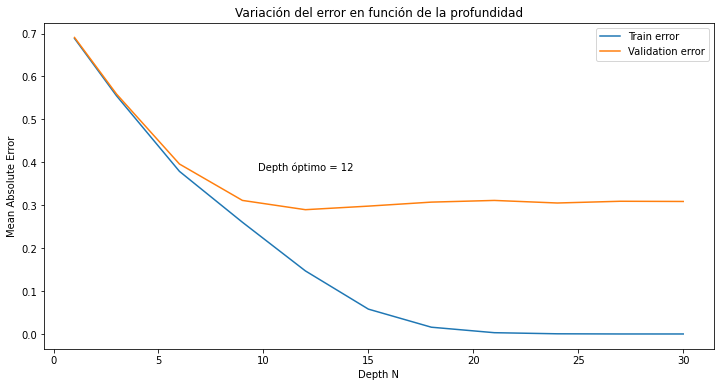

In [ ]:
# Gráficos Variación de N según el error de train y validation
plt.rcParams['figure.figsize'] = [12,6]                                          # Tamaño
error_res = pd.read_csv('error_validation.csv')
plt.plot(error_res["depth"],error_res["train"], label = 'Train error')
plt.plot(error_res["depth"],error_res["val"], label = 'Validation error')
plt.xlabel('Depth N')
plt.ylabel('Mean Absolute Error')
plt.title('Variación del error en función de la profundidad')
plt.legend()
plt.text(12, np.min(error_res["val"])+0.1 , u'Depth óptimo = 12', 
         fontsize = 10, horizontalalignment='center', verticalalignment='center')

**Comentarios:**

Se puede ver que el error de validación disminuye hasta una profunidad 12, despues de dicho punto, el error de validación comienza a aumentar lo que se puede ver overfitting. Por lo tanto, se concluye que la profundidad ideal es 12, pero no necesariamente representa el valor real dado que no se realizó de forma ideal el cross-validation.

In [30]:
# Entrenando el árbol óptimo
treeop = DecisionTreeRegressor(criterion = 'mae',
                             max_depth = 12)
treeop.fit(x_tr_st,y_tr_st)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [31]:
#predicciones árbol
treeop_val = treeop.predict(x_val_st)
treeop_tst = treeop.predict(x_tst_st)

In [32]:
# Cálculo de métricas
metrics_treeop_val, metrics_treeop_tst = metrics(treeop_val, treeop_tst, y_val_st, y_tst_st)

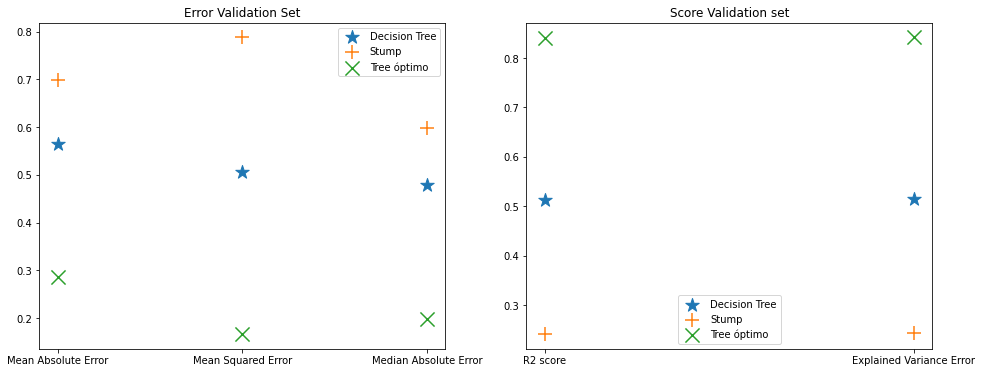

In [76]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# VALIDATION SET
axs[0].scatter(metrics_n[:3],metrics_tree_val[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_stump_val[:3],200,marker='+')
axs[0].scatter(metrics_n[:3],metrics_treeop_val[:3],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_tree_val[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_stump_val[3:],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_treeop_val[3:],200,marker='x')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Decision Tree','Stump','Tree óptimo'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Decision Tree','Stump','Tree óptimo'])

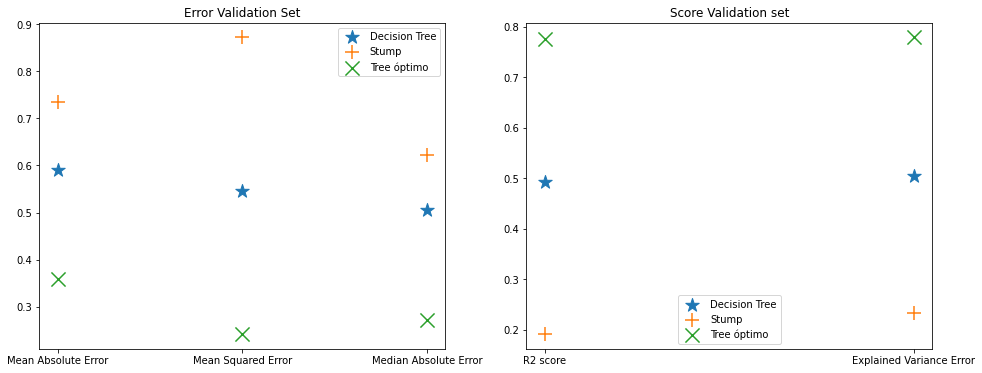

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_tree_tst[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_stump_tst[:3],200,marker='+')
axs[0].scatter(metrics_n[:3],metrics_treeop_tst[:3],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_tree_tst[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_stump_tst[3:],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_treeop_tst[3:],200,marker='x')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Decision Tree','Stump','Tree óptimo'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Decision Tree','Stump','Tree óptimo'])

**Comentarios:**

Gracias a los gráficos anterior, se puede ver que el ajuste con el árbol óptimo es ampliamente mejor que los árboles ajustado previamente en las 5 métricas de comparación. Por lo tanto, se concluye que dicha profundidad es la óptima para el problema en cuestión.

**1.f Random Forest**

En la pregunta anterior vimos que una profundidad de árbol muy grande puede llevarnos a _overfitting_ , pues la cantidad de "decisiones" que puede aprender el modelo aumentan significativamente y el modelo tenderá a aprender de memoria el conjunto de entrenamiento, perdiendo capacidad de generalización.  Otra aproximación para evitar _overfitting_ es no utilizar todos los datos para entrenar, estrategia implementada por _Random Forest_ .

Discuta por qué el utilizar muchos modelos que no conocen todos los datos puede ayudar a mejorar la capacidad de generalización, evitando así que el modelo final esté sobreajustado. Entrene luego un _Random Forest Regressor_ , con a lo menos 10 arboles. Discuta sobre qué elección realizar sobre la profundidad máxima de estos árboles. ¿Cómo se compara el desempeño de _Random Forest_ reste a un árbol por si solo? Ocupe las 5 métricas en el conjunto de validación y test para concluir.

¿Por qué el utilizar muchos modelos que no concen los datos puede ayudar a mejorar la capacidad de generalización? evitando así que el modelo final esté sobreajustado.

**Comentarios:**

Esto es dado que así se reduce la correlación entre las variables lo que genera que el ensamblado pueda reducir la varianza del estimador, por ende, se evita el sobreajuste.

Discuta sobre qué elección realizar sobre la profundidad máxima de estos árboles

**Comentarios:**

Se útiliza la misma profunidad que se encontro con "cross-validation" dado que se obtuvieron buenos resultados al ajustar el árbol óptimo.

In [35]:
forest = RandomForestRegressor(n_estimators=10,
                               criterion='mae',
                               max_depth=12
    )
# n_estimador es la cantidad de árboles 

# Ajustar forest
%timeit -n 1 -r 1 forest.fit(x_tr_st,y_tr_st)

1 loop, best of 1: 45min 12s per loop


In [36]:
# Predicción
forest_val = forest.predict(x_val_st)
forest_tst = forest.predict(x_tst_st)

In [37]:
# Cálculo de métricas
metrics_forest_val, metrics_forest_tst = metrics(forest_val, forest_tst, y_val_st, y_tst_st)

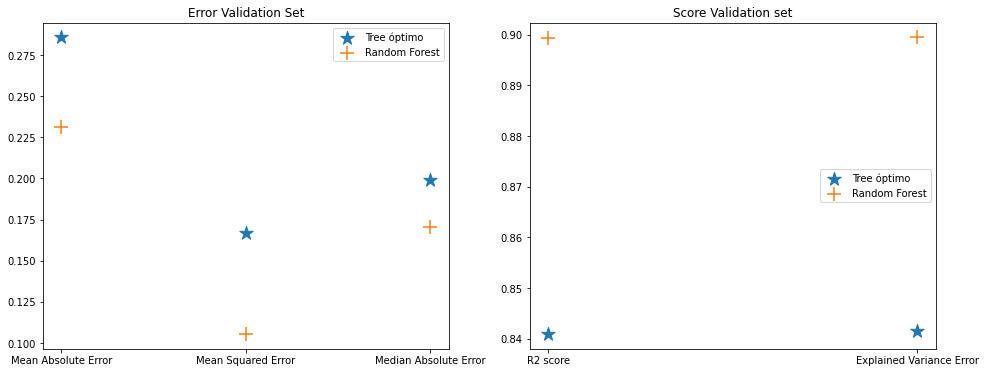

In [78]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# VALIDATION SET
axs[0].scatter(metrics_n[:3],metrics_treeop_val[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_forest_val[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_treeop_val[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_forest_val[3:],200,marker='+')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Tree óptimo','Random Forest'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Tree óptimo','Random Forest'])

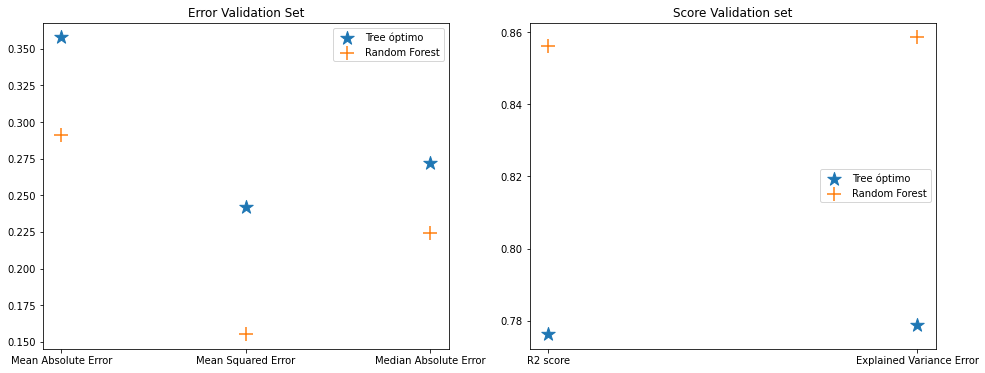

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_treeop_tst[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_forest_tst[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_treeop_tst[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_forest_tst[3:],200,marker='+')
axs[0].set_title("Error Validation Set")
axs[0].legend(['Tree óptimo','Random Forest'])
axs[1].set_title("Score Validation set")
axs[1].legend(['Tree óptimo','Random Forest'])

**Comentarios:**

Como era de esperar, se puede apreciar que el ajuste por Random Forest es mejor que el obtenido con el árbol óptimo debido a que este ensamblado puede reducir la varianza del estimador, ajustando de mejor forma los datos. Una desventaja de Random Forest es que demorá mucho más tiempo en comparación al árbol óptimo.

**1.g Otros parámetros**

Investigue un poco sobre los otros parámetros de los árboles y sus implicancias. Luego, entrene un árbol modificado algunos de sus parámetros según lo que estima que podría haber mejorado el desempeño. Discuta.

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

**Parámetros:**
* Criterion: es la función que mide la calidad de una división. Para esta tarea se ha utilizado el MAE (Mean Absolute Error) el que minimiza la pérdida $L_1$. 
* Max_depth: es la máxima profundidad, donde se ha visto que a medida que aumenta se tiende a sobreajustar, siendo una profundidad de 12 el óptimo para el dataset en cuestión.
* Min_samples_split: corresponde al mínimo número de muestras requeridos para dividir un nodo interno. Por default se tiene un mínimo de 2 muestras, pero puede tomar un valor entero o flotante.
* Min_sample leaf: corresponde al mínimo número de muestras requerido para ser un nodo hoja. Es importante considerar que un punto de división a cualquier profundidad solo se considerará si deja al menos muestras de entrenamientos min_samples_leaf en cada una de las ramas.
* Min_impurity_decrease: un nodo será dividido si la división induce una disminución de la impuridad mayor o igual al valor que se elige.
* Max_leaf_nodes: el árbol crece con un determinado máximo de hojas. Los mejores nodos se definen como una reducción relativa de la impureza.

In [40]:
# Árbol Normal
tree_g = DecisionTreeRegressor(criterion = 'mae',
                              max_depth = None,     
                              min_samples_split = 2,              # Inicial 2, prueba 10
                              min_samples_leaf = 2,               # Inicial 2, prueba 10
                              min_impurity_decrease = 1e-8,       # Inicial 1e-8, prueba 0.1
                              max_leaf_nodes = int(10000*0.6))    # Inicial 10000*0.6, prueba 100*0.6
tree_g.fit(x_tr_st,y_tr_st)                    

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=6000,
                      min_impurity_decrease=1e-08, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

#### Otros árboles

In [41]:
# Árbol Con min_samples_split = 10
tree_g1 = DecisionTreeRegressor(criterion = 'mae',
                              max_depth = None,     
                              min_samples_split = 10,              # Inicial 2, prueba 10
                              min_samples_leaf = 2,                # Inicial 2, prueba 10
                              min_impurity_decrease = 1e-8,        # Inicial 1e-8, prueba 0.1
                              max_leaf_nodes = int(10000*0.6))     # Inicial 10000*0.6, prueba 100*0.6
tree_g1.fit(x_tr_st,y_tr_st)                    

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=6000,
                      min_impurity_decrease=1e-08, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [42]:
# Árbol con min_sample_leaf = 10
tree_g2 = DecisionTreeRegressor(criterion = 'mae',
                              max_depth = None,     
                              min_samples_split = 2,              # Inicial 2, prueba 10
                              min_samples_leaf = 10,               # Inicial 2, prueba 10
                              min_impurity_decrease = 1e-8,       # Inicial 1e-8, prueba 0.1
                              max_leaf_nodes = int(10000*0.6))    # Inicial 10000*0.6, prueba 100*0.6
tree_g2.fit(x_tr_st,y_tr_st)                    

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=6000,
                      min_impurity_decrease=1e-08, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [43]:
# Árbol con min_impurity_decrease = 0.1
tree_g3 = DecisionTreeRegressor(criterion = 'mae',
                              max_depth = None,     
                              min_samples_split = 2,              # Inicial 2, prueba 10
                              min_samples_leaf = 2,               # Inicial 2, prueba 10
                              min_impurity_decrease = 0.1,       # Inicial 1e-8, prueba 0.1
                              max_leaf_nodes = int(10000*0.6))    # Inicial 10000*0.6, prueba 100*0.6
tree_g3.fit(x_tr_st,y_tr_st)                    

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=6000,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [44]:
# Árbol max_leaf_nodes = 100*0.6
tree_g4 = DecisionTreeRegressor(criterion = 'mae',
                              max_depth = None,     
                              min_samples_split = 2,              # Inicial 2, prueba 10
                              min_samples_leaf = 2,               # Inicial 2, prueba 10
                              min_impurity_decrease = 1e-8,       # Inicial 1e-8, prueba 0.1
                              max_leaf_nodes = int(100*0.6))    # Inicial 10000*0.6, prueba 100*0.6
tree_g4.fit(x_tr_st,y_tr_st)                    

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=60,
                      min_impurity_decrease=1e-08, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

#### Predicciones y gráficos

In [45]:
# Predicción árbol sin cambios
tree_g_val = tree_g.predict(x_val_st)
tree_g_tst = tree_g.predict(x_tst_st)
metrics_g_val, metrics_g_tst = metrics(tree_g_val,tree_g_tst, y_val_st, y_tst_st)

# Predicción árbol con cambios 1
tree_g1_val = tree_g1.predict(x_val_st)
tree_g1_tst = tree_g1.predict(x_tst_st)
metrics_g1_val, metrics_g1_tst = metrics(tree_g1_val,tree_g1_tst, y_val_st, y_tst_st)

# Predicción árbol con cambios 2
tree_g2_val = tree_g2.predict(x_val_st)
tree_g2_tst = tree_g2.predict(x_tst_st)
metrics_g2_val, metrics_g2_tst = metrics(tree_g2_val,tree_g2_tst, y_val_st, y_tst_st)

# Predicción árbol con cambios 3
tree_g3_val = tree_g3.predict(x_val_st)
tree_g3_tst = tree_g3.predict(x_tst_st)
metrics_g3_val, metrics_g3_tst = metrics(tree_g3_val,tree_g3_tst, y_val_st, y_tst_st)

# Predicción árbol con cambios 3
tree_g4_val = tree_g4.predict(x_val_st)
tree_g4_tst = tree_g4.predict(x_tst_st)
metrics_g4_val, metrics_g4_tst = metrics(tree_g4_val,tree_g4_tst, y_val_st, y_tst_st)

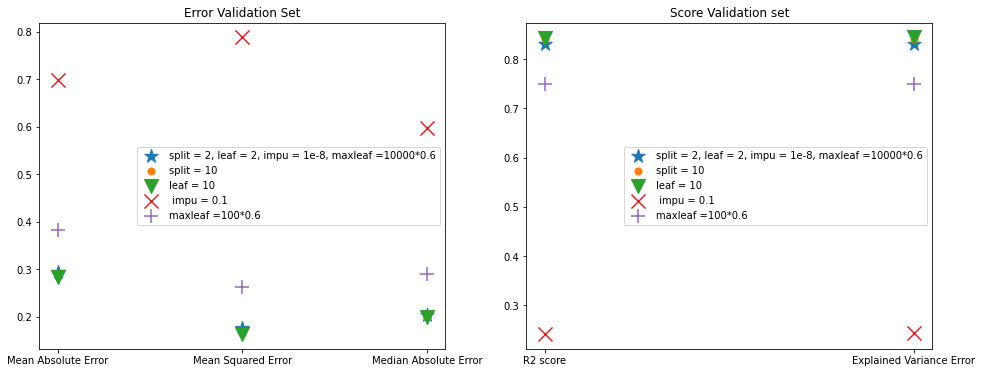

In [79]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# VALIDATION SET
axs[0].scatter(metrics_n[:3],metrics_g_val[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_g1_val[:3],200,marker='.')
axs[0].scatter(metrics_n[:3],metrics_g2_val[:3],200,marker='v')
axs[0].scatter(metrics_n[:3],metrics_g3_val[:3],200,marker='x')
axs[0].scatter(metrics_n[:3],metrics_g4_val[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_g_val[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_g1_val[3:],200,marker='.')
axs[1].scatter(metrics_n[3:],metrics_g2_val[3:],200,marker='v')
axs[1].scatter(metrics_n[3:],metrics_g3_val[3:],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_g4_val[3:],200,marker='+')
axs[0].set_title("Error Validation Set")
axs[0].legend(['split = 2, leaf = 2, impu = 1e-8, maxleaf =10000*0.6','split = 10','leaf = 10',' impu = 0.1', 'maxleaf =100*0.6'])
axs[1].set_title("Score Validation set")
axs[1].legend(['split = 2, leaf = 2, impu = 1e-8, maxleaf =10000*0.6','split = 10','leaf = 10',' impu = 0.1', 'maxleaf =100*0.6'])

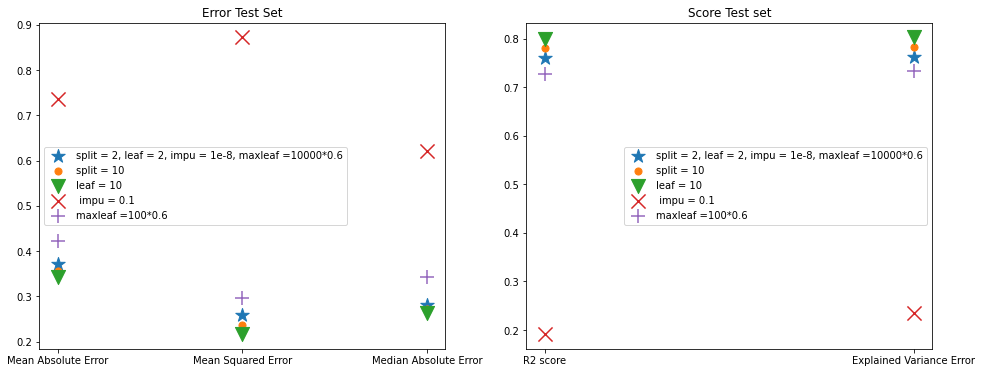

In [80]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_g_tst[:3],200,marker='*')
axs[0].scatter(metrics_n[:3],metrics_g1_tst[:3],200,marker='.')
axs[0].scatter(metrics_n[:3],metrics_g2_tst[:3],200,marker='v')
axs[0].scatter(metrics_n[:3],metrics_g3_tst[:3],200,marker='x')
axs[0].scatter(metrics_n[:3],metrics_g4_tst[:3],200,marker='+')
axs[1].scatter(metrics_n[3:],metrics_g_tst[3:],200,marker='*')
axs[1].scatter(metrics_n[3:],metrics_g1_tst[3:],200,marker='.')
axs[1].scatter(metrics_n[3:],metrics_g2_tst[3:],200,marker='v')
axs[1].scatter(metrics_n[3:],metrics_g3_tst[3:],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_g4_tst[3:],200,marker='+')
axs[0].set_title("Error Test Set")
axs[0].legend(['split = 2, leaf = 2, impu = 1e-8, maxleaf =10000*0.6','split = 10','leaf = 10',' impu = 0.1', 'maxleaf =100*0.6'])
axs[1].set_title("Score Test set")
axs[1].legend(['split = 2, leaf = 2, impu = 1e-8, maxleaf =10000*0.6','split = 10','leaf = 10',' impu = 0.1', 'maxleaf =100*0.6'])

**Comentarios** 

Se puede ver que el parámetro que mejora la predicción del árbol corresponde a min_sample_leaf = 10. Por lo tanto se compara este modelo con el modelo RandomForest, dado que es el mejor predictor hasta el momento.

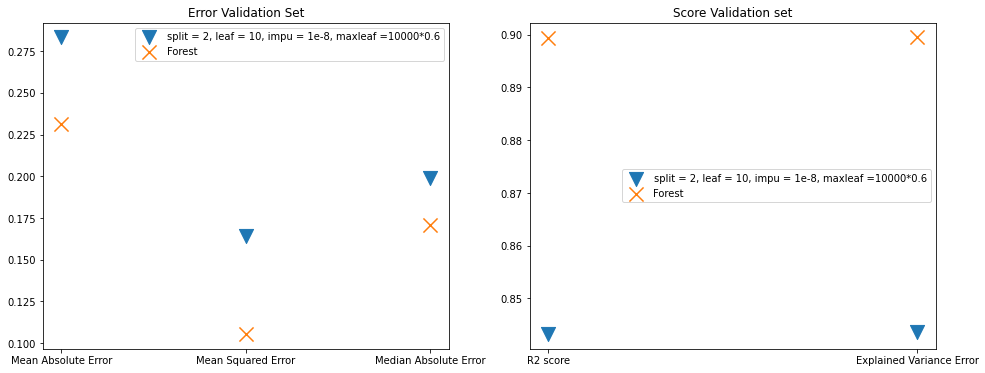

In [81]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# VALIDATION SET
axs[0].scatter(metrics_n[:3],metrics_g2_val[:3],200,marker='v')
axs[0].scatter(metrics_n[:3],metrics_forest_val[:3],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_g2_val[3:],200,marker='v')
axs[1].scatter(metrics_n[3:],metrics_forest_val[3:],200,marker='x')
axs[0].set_title("Error Validation Set")
axs[0].legend(['split = 2, leaf = 10, impu = 1e-8, maxleaf =10000*0.6','Forest'])
axs[1].set_title("Score Validation set")
axs[1].legend(['split = 2, leaf = 10, impu = 1e-8, maxleaf =10000*0.6','Forest'])

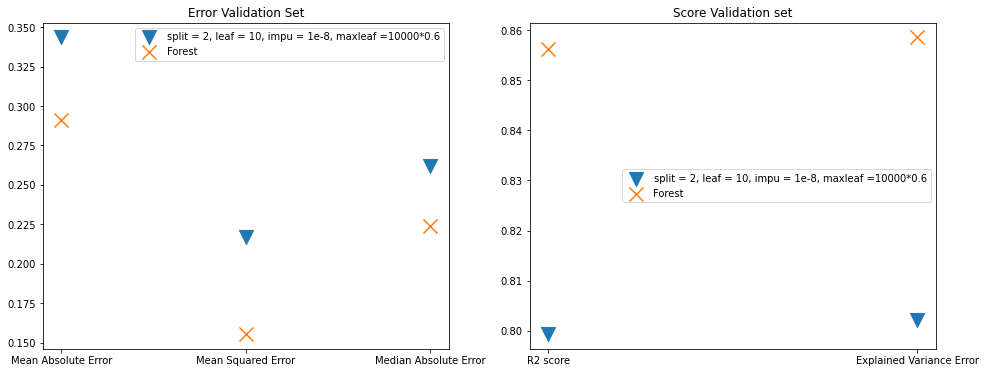

In [82]:
# Gráficos
metrics_n = ['Mean Absolute Error', 'Mean Squared Error', 'Median Absolute Error',
                'R2 score', 'Explained Variance Error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# TEST SET
axs[0].scatter(metrics_n[:3],metrics_g2_tst[:3],200,marker='v')
axs[0].scatter(metrics_n[:3],metrics_forest_tst[:3],200,marker='x')
axs[1].scatter(metrics_n[3:],metrics_g2_tst[3:],200,marker='v')
axs[1].scatter(metrics_n[3:],metrics_forest_tst[3:],200,marker='x')
axs[0].set_title("Error Validation Set")
axs[0].legend(['split = 2, leaf = 10, impu = 1e-8, maxleaf =10000*0.6','Forest'])
axs[1].set_title("Score Validation set")
axs[1].legend(['split = 2, leaf = 10, impu = 1e-8, maxleaf =10000*0.6','Forest'])

**Comentarios:** 

Se puede ver que Random Forest sigue siendo mejor ajuste para los datos en cuestión para todas las métricas en cuestión. Por lo tanto, la última parte de esta parte de la tarea se utilizará Random Forest para la predicción.

**1.h Análisis de predicción para los distintos intervalos de tiempo**

Quédese con el mejor modelo entrenado hasta el momento. Calcule el error MSE para cada una de las 24 horas que se está prediciendo con el conjunto de test. Grafique cómo varía el MSE para cada una de las 24 horas. Concluya.

In [67]:
error_per_hour = []

for i in range(24): 
    error_per_hour.append(mean_squared_error(y_tst_st[:,i],forest_tst[:,i]))

Text(0.5, 1.0, 'Variación del error en de 24 horas')

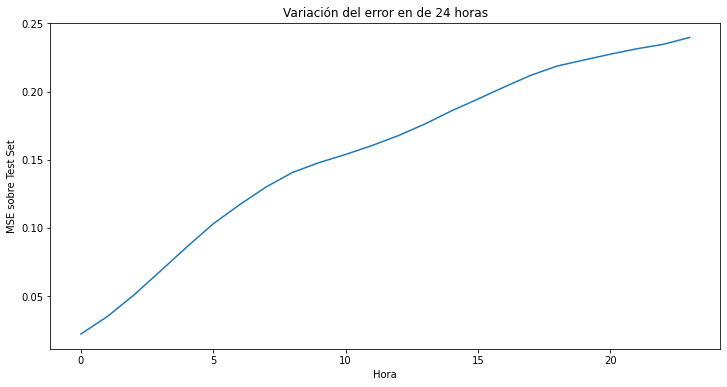

In [69]:
#Gráfico de error
plt.rcParams['figure.figsize'] = [12,6]                                          # Tamaño
plt.plot(range(24),error_per_hour)
plt.xlabel('Hora')
plt.ylabel('MSE sobre Test Set')
plt.title('Variación del error en de 24 horas')

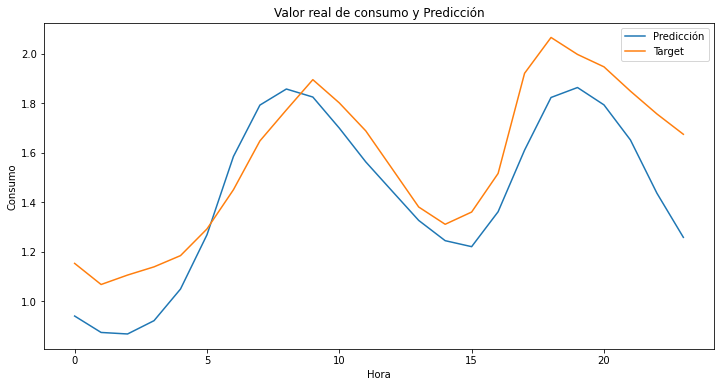

In [90]:
#Gráfico de error
plt.rcParams['figure.figsize'] = [12,6]                                          # Tamaño
plt.plot(range(24),forest_tst[0,:], label = 'Predicción')
plt.plot(range(24),y_tst_st[0,:], label = 'Target')
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.title('Valor real de consumo y Predicción')
plt.legend()

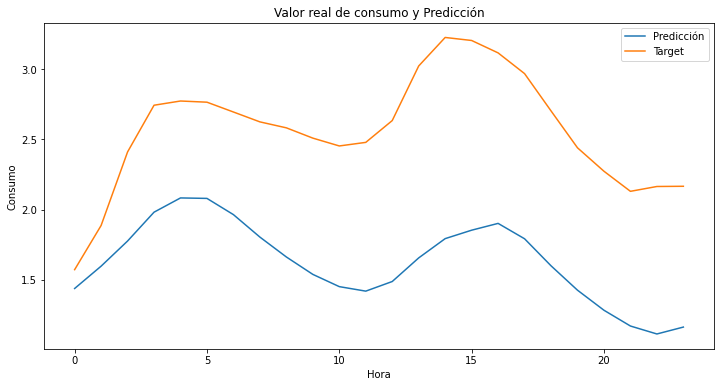

In [91]:
#Gráfico de error
plt.rcParams['figure.figsize'] = [12,6]                                          # Tamaño
plt.plot(range(24),forest_tst[100,:], label = 'Predicción')
plt.plot(range(24),y_tst_st[100,:], label = 'Target')
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.title('Valor real de consumo y Predicción')
plt.legend()

**Comentarios:** 

Finalmente se realiza la predicción utilizando el mejor ajuste, es decir, Random Forest. Se puede ver que a medida que pasan las horas, la predicción se aleja del target lo que puede explicar que el error aumente a medida que aumentan las horas. De todas formas, las métricas obtenidas son buenas.